# Fix samples that share reads

1. Run `fix_mix_index_samples.sh`
2. Load output file `indices.txt` into the notebook

In [73]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
import gzip, re, sys, ipynb, requests
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from ftplib import FTP
from bs4 import BeautifulSoup
from ipynb.fs.defs.make_sample_sheet import find_logg_files, fields

## find fastq files on the server

In [74]:
logg_files = find_logg_files()
logg_cells = set(logg_files["sample_id"].str.upper())

  0%|          | 0/14098 [00:00<?, ?it/s]

found 14098 files
extracting first read from each file

		14098 files
		8886 unique files based on first read
		
Found 4438 unique samples with both R1 and R2 reads


##  Get names of bad files Meiyan, and Eran

In [75]:
# from Eran
with open("../resources/potential_mixed_cells_Eran.txt", "r") as f:
    eran_cells = set([line.strip().upper() for line in f.readlines()])
print(f"Loaded {len(eran_cells)} potential mixed cells from Eran's analysis")

Loaded 99 potential mixed cells from Eran's analysis


In [76]:
# from Meiyan
def get_cells_igc(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    links = soup.find_all("a")
    return set(
        [
            re.sub("_R1_001.fastq.gz$", "", link.get("href")).upper()
            for link in links
            if "_R1_001.fastq.gz" in link.get("href")
        ]
    )


meiyan_cells = get_cells_igc(
    "http://igc2.salk.edu/illumina/runs/190604_PE125A/Gage_Meiyan/"
)  # corrected?
print(f"Loaded {len(meiyan_cells)} potential mixed cells from Meiyan's analysis")

# write to file
with open("../resources/potential_mixed_cells_Meiyan.txt", "w") as f:
    for cell in meiyan_cells:
        f.write(cell + "\n")

Loaded 331 potential mixed cells from Meiyan's analysis


In [77]:
# intersect
mixed_cells = eran_cells.intersection(meiyan_cells)
print(f"Found {len(mixed_cells)} potential mixed cells in both analyses")
print(mixed_cells)

Found 2 potential mixed cells in both analyses
{'USH25_D2_S12', 'USH25_F2_S14'}


## inspect duplicated flowcell_index across fastqs

/>1 files have the same flowcell_index



In [78]:
# inspect duplicated reads across files
pd.set_option("display.max_colwidth", None)

# load unique flowcell indices by fastq file
df = pd.read_csv("indices.txt", sep="\t", names=["filename", "flowcell_index"])
df["Read"] = df["filename"].str.extract(r"_(R[12])")
df = pd.DataFrame.from_records([dict(fields(x)) for x in df["filename"]]).merge(
    df, on="filename"
)
# df = df[df["individual"] != "CommonBrain"]
df["cell_id"] = df["pair_id"].str.upper()
df["flowcell_index"] = df["flowcell_index"].apply(
    lambda x: tuple(x.rstrip(",").split(","))
)
# df = df[~df["cell_id"].str.contains("GDNA")]

df = (
    df[~df[["cell_id", "flowcell_index"]].duplicated(keep="first")]
    .explode("flowcell_index")
    .reset_index(drop=True)
)

with open("../resources/bad_cells.txt") as f:
    bad_cells = set([line.strip().upper() for line in f.readlines()])

# remove bad_cells
df = df[~df["cell_id"].isin(bad_cells)]
df = (
    df[["filename", "cell_id", "flowcell_index", "Read"]]
    .sort_values("cell_id")
    .reset_index(drop=True)
)

print(
    f"Loaded flowcell index for {df.filename.nunique()} files from {df.cell_id.nunique()} cells"
)
if df.filename.nunique() != (2 * df.cell_id.nunique()):
    print("Warning: not all files have unique cell_id")
else:
    print("All files have unique cell_id!")

Loaded flowcell index for 8526 files from 4263 cells
All files have unique cell_id!


In [79]:
eran_cells = set(df["cell_id"]).intersection(eran_cells)
print(f"Found {len(eran_cells)} potential mixed cells from Eran's analysis")
meiyan_cells = set(df["cell_id"]).intersection(meiyan_cells)
print(f"Found {len(meiyan_cells)} potential mixed cells from Meiyan's analysis")

Found 25 potential mixed cells from Eran's analysis
Found 61 potential mixed cells from Meiyan's analysis


In [80]:
# flag cells if they share flowcell indices
# find flowcells that have 1 or more files
flowcells = df.groupby("flowcell_index")["filename"].nunique()
print("n_files unique to n_flowcells:")
print(flowcells.value_counts().sort_index())
flagged_flowcells = flowcells[flowcells > 1].index.tolist()

flagged_files = (
    df.groupby(["filename", "cell_id"])["flowcell_index"]
    .apply(lambda x: len(set(x).intersection(flagged_flowcells)))
    .reset_index(name="n_shared_flowcells")
    .query("n_shared_flowcells > 0")
)

print(
    f"Found {flagged_files.filename.nunique()} files from {flagged_files.cell_id.nunique()} cells with shared flowcell indices"
)

n_files unique to n_flowcells:
filename
1    9914
2      68
Name: count, dtype: int64
Found 136 files from 68 cells with shared flowcell indices


In [81]:
my_cells = set(flagged_files["cell_id"])

inter = my_cells.intersection(eran_cells)
print(
    f"Found {len(inter)} potential mixed cells from Eran's analysis with shared flowcell indices"
)

diff = eran_cells.difference(my_cells)
print(
    f"Found {len(diff)} potential mixed cells from Eran's analysis without shared flowcell indices"
)

diff = my_cells.difference(eran_cells)
print(
    f"Found {len(diff)} potential mixed cells from my analysis not in Eran's analysis"
)

inter = my_cells.intersection(meiyan_cells)
print(
    f"Found {len(inter)} potential mixed cells from Meiyan's analysis with shared flowcell indices"
)

inter = my_cells.intersection(meiyan_cells).intersection(eran_cells)
print(
    f"Found {len(inter)} potential mixed cells in both analyses with shared flowcell indices"
)

Found 17 potential mixed cells from Eran's analysis with shared flowcell indices
Found 8 potential mixed cells from Eran's analysis without shared flowcell indices
Found 51 potential mixed cells from my analysis not in Eran's analysis
Found 3 potential mixed cells from Meiyan's analysis with shared flowcell indices
Found 2 potential mixed cells in both analyses with shared flowcell indices


In [82]:
my_df = (
    df[df["cell_id"].isin(eran_cells.difference(my_cells)) & (df["Read"] == "R1")]
    .groupby("flowcell_index")["cell_id"]
    .nunique()
)
my_df.value_counts().sort_index()

my_df = (
    df[df["cell_id"].isin(eran_cells.difference(my_cells)) & (df["Read"] == "R1")]
    .groupby("cell_id")["flowcell_index"]
    .nunique()
)
my_df.value_counts().sort_index()

flowcell_index
1    5
2    3
Name: count, dtype: int64

In [83]:
# how many files have a unique flowcell index?
good_files = df[~df["filename"].isin(flagged_files["filename"])]
print(
    f"Found {good_files.filename.nunique()} files with {good_files.flowcell_index.nunique()} unique flowcell indices across {good_files.cell_id.nunique()} cells"
)

Found 8390 files with 9876 unique flowcell indices across 4195 cells


In [84]:
# how many files have a duplicated flowcell index?
bad_files = df[df["filename"].isin(flagged_files["filename"])].copy()
bad_files["bad_flowcell_index"] = bad_files["flowcell_index"].apply(
    lambda x: x in flagged_flowcells
)

In [85]:
res = []
before = []

for f in bad_files[bad_files["bad_flowcell_index"]]["flowcell_index"].unique():
    files = bad_files.query("flowcell_index == @f")["filename"].unique()
    my_df = bad_files.query("filename in @files")
    # print(f"Flowcell {f} was found across {my_df.shape[0]} files")
    # print(f"{my_df.shape[0]} files with flowcell {f} have {my_df.flowcell_index.nunique()} unique flowcells")
    if my_df.flowcell_index.nunique() == 1:
        res.append(
            {
                "filename": my_df.filename.values[0],
                "cell_id": my_df.cell_id.values[0],
                "flowcell_indices": f,
                "flowcell_indices_to_remove": None,
                "flowcell_indices_to_keep": f,
                "outfile": "../data/" + Path(my_df.filename.values[0]).name,
            }
        )
    else:
        assert my_df.shape[0] == 3, f"flowcell {f} has {my_df.shape[0]} rows"
        my_df_files = my_df.groupby("filename").size()
        file_with_multiple = my_df_files[my_df_files > 1].index.tolist()[0]
        file_with_one = my_df_files[my_df_files == 1].index.tolist()[0]
        flowcell_all = my_df.query("filename == @file_with_multiple")[
            "flowcell_index"
        ].values
        flowcell_to_remove = my_df.query("filename == @file_with_one")[
            "flowcell_index"
        ].values[0]
        res.append(
            {
                "filename": file_with_multiple,
                "cell_id": my_df.query("filename == @file_with_multiple")[
                    "cell_id"
                ].values[0],
                "flowcell_indices": flowcell_all,
                "flowcell_indices_to_remove": flowcell_to_remove,
                "flowcell_indices_to_keep": list(
                    set(flowcell_all) - set([flowcell_to_remove])
                )[0],
                "outfile": "../data/" + Path(file_with_multiple).name,
            }
        )
    before.append(my_df)
res = pd.DataFrame.from_records(res)
res["outfile"] = res.outfile.apply(lambda x: str(Path(x).resolve()))
before = pd.concat(before)
my_cells = set(before.cell_id)
print(f"Found {len(my_cells)} potential mixed cells in logg files")
res.head()

Found 68 potential mixed cells in logg files


,filename,cell_id,flowcell_indices,flowcell_indices_to_remove,flowcell_indices_to_keep,outfile
0,/iblm/logglun01/fqiu/AWS/for-ndar/SLAV-Seq/USD30/USD30_A3_S104_R1_001.fastq.gz,USD30_A3_S104,"[@D00220 cdmmtanxx 4 1:N:0:CAGGCG, @D00220 cdmmtanxx 3 1:N:0:CGATGT]",@D00220 cdmmtanxx 4 1:N:0:CAGGCG,@D00220 cdmmtanxx 3 1:N:0:CGATGT,/iblm/netapp/data3/mcuoco/sz_slavseq/data/USD30_A3_S104_R1_001.fastq.gz
1,/iblm/logglun01/fqiu/AWS/for-ndar/SLAV-Seq/USD30/USD30_A3_S104_R2_001.fastq.gz,USD30_A3_S104,"[@D00220 cdmmtanxx 4 2:N:0:CAGGCG, @D00220 cdmmtanxx 3 2:N:0:CGATGT]",@D00220 cdmmtanxx 4 2:N:0:CAGGCG,@D00220 cdmmtanxx 3 2:N:0:CGATGT,/iblm/netapp/data3/mcuoco/sz_slavseq/data/USD30_A3_S104_R2_001.fastq.gz
2,/iblm/logglun01/fqiu/AWS/for-ndar/SLAV-Seq/USD30/USD30_A4_S112_R2_001.fastq.gz,USD30_A4_S112,"[@D00220 cdmmtanxx 4 2:N:0:GCGCTA, @D00220 cdmmtanxx 3 2:N:0:ACTTGA]",@D00220 cdmmtanxx 4 2:N:0:GCGCTA,@D00220 cdmmtanxx 3 2:N:0:ACTTGA,/iblm/netapp/data3/mcuoco/sz_slavseq/data/USD30_A4_S112_R2_001.fastq.gz
3,/iblm/logglun01/fqiu/AWS/for-ndar/SLAV-Seq/USD30/USD30_A4_S112_R1_001.fastq.gz,USD30_A4_S112,"[@D00220 cdmmtanxx 3 1:N:0:ACTTGA, @D00220 cdmmtanxx 4 1:N:0:GCGCTA]",@D00220 cdmmtanxx 4 1:N:0:GCGCTA,@D00220 cdmmtanxx 3 1:N:0:ACTTGA,/iblm/netapp/data3/mcuoco/sz_slavseq/data/USD30_A4_S112_R1_001.fastq.gz
4,/iblm/logglun01/fqiu/AWS/for-ndar/SLAV-Seq/USD30/USD30_B4_S113_R2_001.fastq.gz,USD30_B4_S113,"[@D00220 cdmmtanxx 3 2:N:0:GATCAG, @D00220 cdmmtanxx 4 2:N:0:TAATCG]",@D00220 cdmmtanxx 4 2:N:0:TAATCG,@D00220 cdmmtanxx 3 2:N:0:GATCAG,/iblm/netapp/data3/mcuoco/sz_slavseq/data/USD30_B4_S113_R2_001.fastq.gz


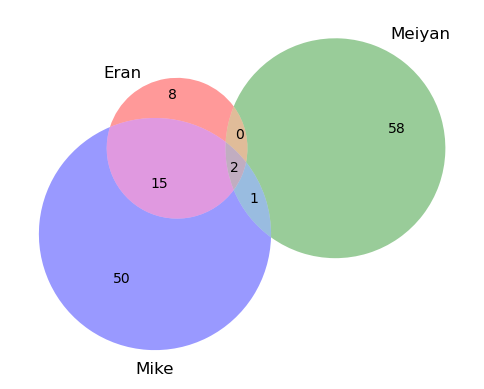

In [86]:
# make venn diagram with eran and meiyan cells
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

venn3([eran_cells, meiyan_cells, my_cells], set_labels=("Eran", "Meiyan", "Mike"))

In [87]:
# fix the files
for row in res.itertuples():
    if Path(row.outfile).exists():
        print(f"skipping {row.outfile}")
        continue
    cmd = f"zcat {row.filename} | grep -A 3 '{row.flowcell_indices_to_keep.split(' ')[-1]}' | gzip -c > {row.outfile}"
    print(f"running: {cmd}")
    !{cmd}

skipping /iblm/netapp/data3/mcuoco/sz_slavseq/data/USD30_A3_S104_R1_001.fastq.gz
skipping /iblm/netapp/data3/mcuoco/sz_slavseq/data/USD30_A3_S104_R2_001.fastq.gz
skipping /iblm/netapp/data3/mcuoco/sz_slavseq/data/USD30_A4_S112_R2_001.fastq.gz
skipping /iblm/netapp/data3/mcuoco/sz_slavseq/data/USD30_A4_S112_R1_001.fastq.gz
skipping /iblm/netapp/data3/mcuoco/sz_slavseq/data/USD30_B4_S113_R2_001.fastq.gz
skipping /iblm/netapp/data3/mcuoco/sz_slavseq/data/USD30_B4_S113_R1_001.fastq.gz
skipping /iblm/netapp/data3/mcuoco/sz_slavseq/data/USD30_C4_S114_R2_001.fastq.gz
skipping /iblm/netapp/data3/mcuoco/sz_slavseq/data/USD30_C4_S114_R1_001.fastq.gz
skipping /iblm/netapp/data3/mcuoco/sz_slavseq/data/USD30_F4_S117_R2_001.fastq.gz
skipping /iblm/netapp/data3/mcuoco/sz_slavseq/data/USD30_F4_S117_R1_001.fastq.gz
skipping /iblm/netapp/data3/mcuoco/sz_slavseq/data/USH11_A5_S75_R1_001.fastq.gz
skipping /iblm/netapp/data3/mcuoco/sz_slavseq/data/USH11_A5_S75_R2_001.fastq.gz
skipping /iblm/netapp/data3/mc

In [88]:
# save new samplesheet
meta = pd.read_csv("slavseq_metadata.tsv", sep="\t").drop(
    ["MDA_PERFORMED", "BULK_PERFORMED"], axis=1
)
meta.columns = meta.columns.str.lower()
meta.set_index("tissue_id", inplace=True)
meta.loc["CommonBrain", "libd_id"] = "CommonBrain"


out = (
    good_files.drop(columns=["Read", "flowcell_index"])
    .drop_duplicates()
    .to_dict(orient="records")
)
for r in res.itertuples():
    out.append({"filename": r.outfile, "cell_id": r.cell_id})

out = pd.DataFrame.from_records(out)
out = pd.DataFrame.from_records([dict(fields(x)) for x in out["filename"]]).merge(
    out, on="filename"
)
# unstack read1 and read2
out = (
    out.pivot(
        columns="read",
        values="filename",
        index=["pair_id", "individual", "dna_type", "tissue_id"],
    )
    .reset_index()
    .rename(columns={"pair_id": "sample_id", "individual": "donor_id"})
    .dropna(subset=["R1", "R2"])
)

# switch gdna 13 and 14 to fix sample swap issue
out.loc[out["sample_id"] == "gDNA_usd13", "donor_id"] = "14"
out.loc[out["sample_id"] == "gDNA_usd13", "tissue_id"] = "USD14"
out.loc[out["sample_id"] == "gDNA_usd14", "donor_id"] = "13"
out.loc[out["sample_id"] == "gDNA_usd14", "tissue_id"] = "USD13"
out.loc[
    (out["dna_type"] == "bulk") & (out["tissue_id"] == "USD14"), "sample_id"
] = "gDNA_usd14"
out.loc[
    (out["dna_type"] == "bulk") & (out["tissue_id"] == "USD13"), "sample_id"
] = "gDNA_usd13"

out.join(meta, on="tissue_id").to_csv("all_samples.tsv", sep="\t", index=False)